In [2]:
import importlib
import os

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Import relevant python packages
from gpet import utils, edgetrace, dataset
%matplotlib inline

In [59]:
importlib.reload(utils)
importlib.reload(dataset)

<module 'gpet_oct.dataset' from '/Users/uzaykaradag/Documents/School/Dissertation/gpr-oct-segmentation/gpet_oct/dataset.py'>

### Loading and splitting the dataset
Here the dataset is loaded as scans and masks and split into an **80-20 train-test** split. This results in **4192 train** samples from and **1048 test** samples.

In [4]:
scan_dir = '../data/scans'
mask_dir = '../data/masks'

# Get the list of scan and mask filenames
scan_files = os.listdir(scan_dir)
mask_files = os.listdir(mask_dir)

# Ensure the filenames match between scans and masks
assert len(scan_files) == len(mask_files), "Number of scans and masks do not match!"
for scan_file, mask_file in zip(scan_files, mask_files):
    assert scan_file == mask_file, f"Scan file {scan_file} does not match mask file {mask_file}!"

# Split the filenames into train and test sets
train_files, test_files = train_test_split(scan_files, test_size=0.2, random_state=42)

### Preprocessing the data
Here I preprocess the dataset so that:
- The scans and the masks are **resized** to be the same shape, here I pick (350, 500) since it's the average shape
- The scans are made to be true **grayscale**
- The masks are used to extract the coordinates of the **groundtruth edge** (ELM)

In [5]:
# Load the training data
train_scans, train_elm_coords = dataset.load_dataset(train_files, scan_dir, mask_dir)

# Load the testing data
test_scans, test_elm_coords = dataset.load_dataset(test_files, scan_dir, mask_dir)

# Print some information about the loaded data
print(f"Number of training samples: {len(train_scans)}")
print(f"Number of testing samples: {len(test_scans)}")
print(f"Shape of first training scan: {train_scans[0].shape}")  # Checking the resizing was done correctly
print(f"Number of ELM coordinates in first training mask: {len(train_elm_coords[0])}")

Number of training samples: 4192
Number of testing samples: 1048
Shape of first training scan: (253, 718)
Number of ELM coordinates in first training mask: 2242


In [6]:
# Test the function using a singular scan
test_idx = 20
test_scan = train_scans[test_idx]
test_elm = train_elm_coords[test_idx]

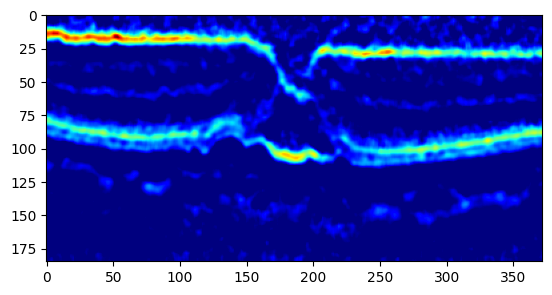

In [7]:
# Create a kernel for edge detection
kernel = utils.kernel_builder(size=(21, 5), unit=False, normalize=True)
# Compute the gradient image
test_edge_map = utils.comp_grad_img(test_scan, kernel)

plt.imshow(test_edge_map, cmap='jet')

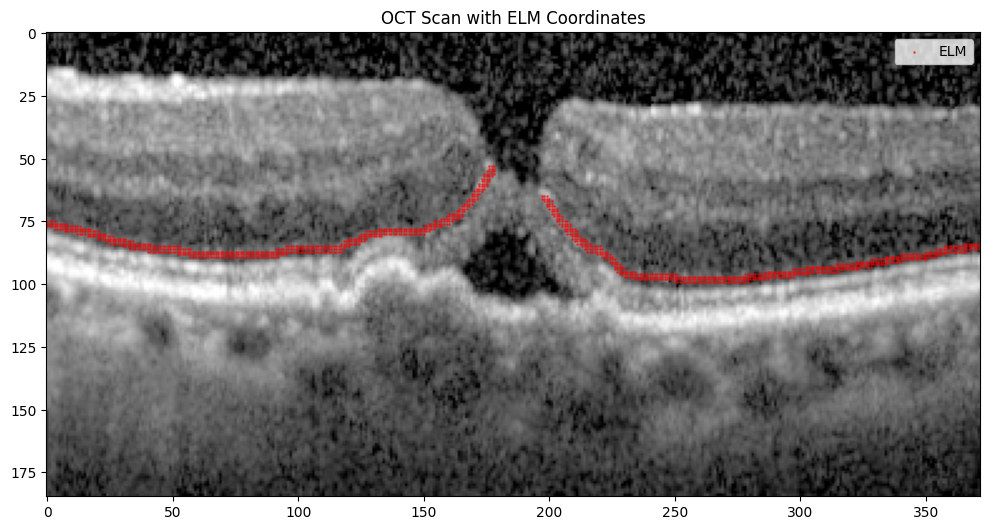

In [57]:
utils.plot_elm(test_scan, test_elm)

In [9]:
test_elm

array([[ 76,   0],
       [ 77,   0],
       [ 75,   0],
       ...,
       [ 84, 371],
       [ 85, 371],
       [ 86, 371]])

In [10]:
# Get initialization edges from the true_elm_coords aka mask
init = test_elm[[0, -1], :][:, [1, 0]]
init

array([[  0,  76],
       [371,  86]])

## Experiment 1: Comparing Exponetial Sine Squared and Matern Kernels
In this experiment we compare the performances of the `ExpSineSquared` kernel with the `Matern` kernel with only the `init` points passed to the `GPEdgeTracer` instance.

In [11]:
importlib.reload(gpet)

<module 'gpet_oct.gpet' from '/Users/uzaykaradag/Documents/School/Dissertation/gpr-oct-segmentation/gpet_oct/gpet.py'>

In [41]:
kernel_options = {
    'kernel': 'ExpSineSquared',
    'sigma_f': 1.0,
    'length_scale': 10.0,
    'period': 10.0
}

gp_tracer_exp = gpet.GPEdgeTracer(init, test_edge_map, kernel_options=kernel_options)
elm_pred_exp = gp_tracer_exp()

In [43]:
kernel_options = {'kernel': 'Matern', 'sigma_f': 60, 'length_scale': 20, 'nu': 2.5}

gp_tracer_mt = gpet.GPEdgeTracer(init, test_edge_map, kernel_options=kernel_options)
elm_pred_mt = gp_tracer_mt()

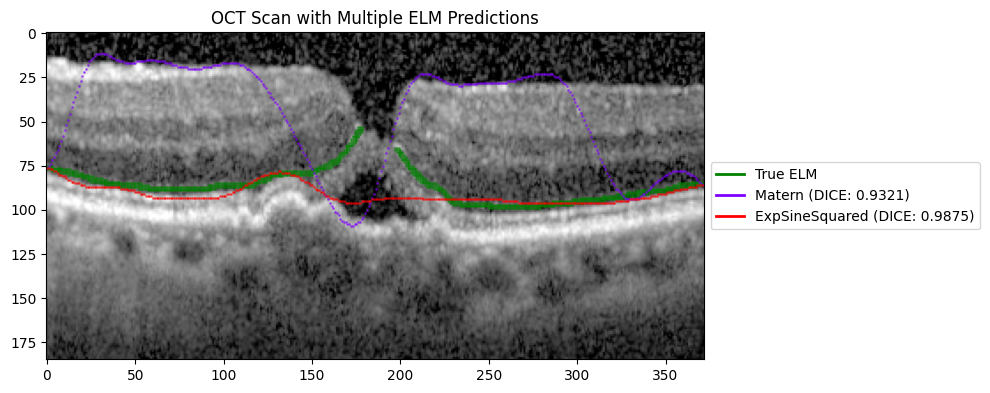

In [60]:
predictions = {'Matern': elm_pred_mt, 'ExpSineSquared': elm_pred_exp}
utils.compare_elm_predictions(test_scan, predictions, test_elm, figsize=(10, 10))

## Experiment 2: The Use of Linearly Space Observations with the Exponential Sine Sq. Kernel
Here the use of the `obs` variable makes for better results which can be seen in the figure down below. We parse the mask to provide the `GPEdgeTracer` instance with 50 linearly spaced points that are **known** to be on the actual ELM.

In [61]:
num_rows = test_elm.shape[0]

start, stop = 0, num_rows - 1
row_indices = np.linspace(start, stop, num=20, dtype=int)

test_obs_lp = test_elm[row_indices, :]

test_obs_lp = test_obs_lp[test_obs_lp[:, 0].argsort()]

test_obs_lp

array([[ 60, 172],
       [ 72, 202],
       [ 74, 157],
       [ 76,   0],
       [ 79, 137],
       [ 81,  18],
       [ 83, 118],
       [ 86,  98],
       [ 86,  37],
       [ 86, 215],
       [ 86, 371],
       [ 89,  78],
       [ 89, 351],
       [ 89,  57],
       [ 90, 331],
       [ 94, 312],
       [ 95, 291],
       [ 96, 230],
       [ 96, 251],
       [ 98, 272]])

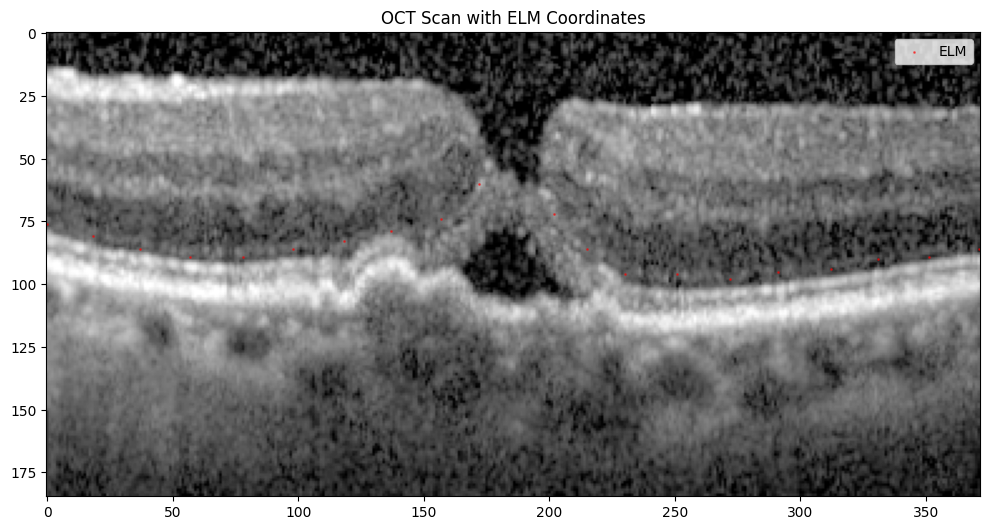

In [62]:
utils.plot_elm(test_scan, test_obs_lp)

In [63]:
test_obs_lp[:, [0, 1]] = test_obs_lp[:, [1, 0]]

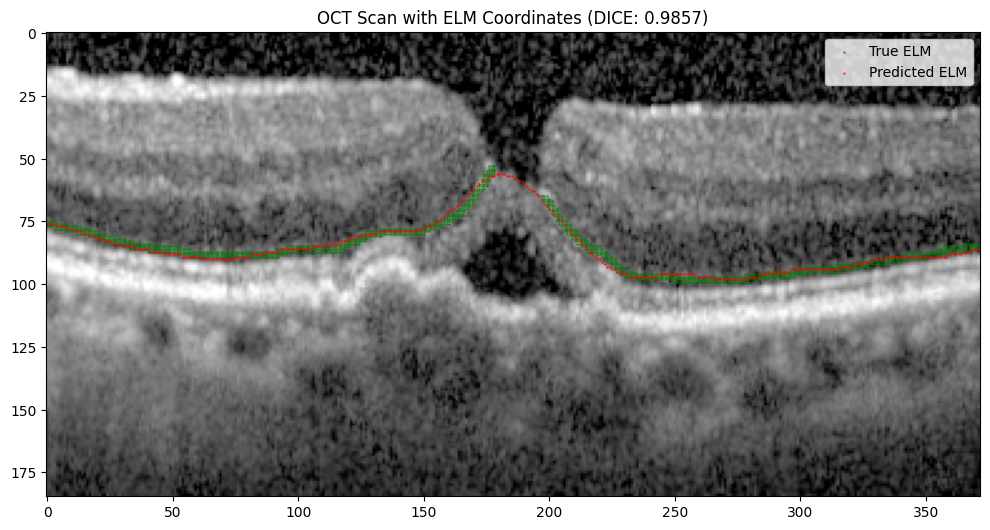

In [64]:
gp_kwargs_obs_lp = dict(
    kernel_options={
        'kernel': 'ExpSineSquared',
        'sigma_f': 1.0,
        'length_scale': 5.0,
        'period': 50.0
    },
    obs=test_obs_lp
)

# Instantiate algorithm using parameters in __init__()
elm_trace_exp = gpet.GPEdgeTracer(init, test_edge_map, **gp_kwargs_obs_lp)

elm_pred_exp = elm_trace_exp()

utils.plot_elm(test_scan, elm_pred_exp, compare=True, true_elm_coords=test_elm)

## Experiment 3: Varying the Hyperparameters for the ExpSineSquared Kernel
1. **sigma_f (amplitude):**

This parameter controls the overall amplitude of the kernel function. In the context of edge tracing:
- A larger sigma_f allows for larger variations in the ELM line's position.
- A smaller sigma_f constrains the ELM line to stay closer to its mean position.
---

2. **length_scale:**

This parameter determines the characteristic length over which the function varies. For edge tracing:
- A larger length_scale results in smoother, less rapidly changing ELM traces. This is useful if you expect the ELM to have gradual, smooth changes across the image.
- A smaller length_scale allows for more rapid changes in the ELM position, which might be necessary if the ELM has sharp curves or discontinuities.
---

3. **period:**

This parameter determines the periodicity of the kernel function. In the context of ELM tracing:
- A larger period suggests that similar patterns in the ELM shape might repeat over longer distances.
- A smaller period allows for more frequent repetitions of patterns, which might be useful if the ELM has regular, repeating features.

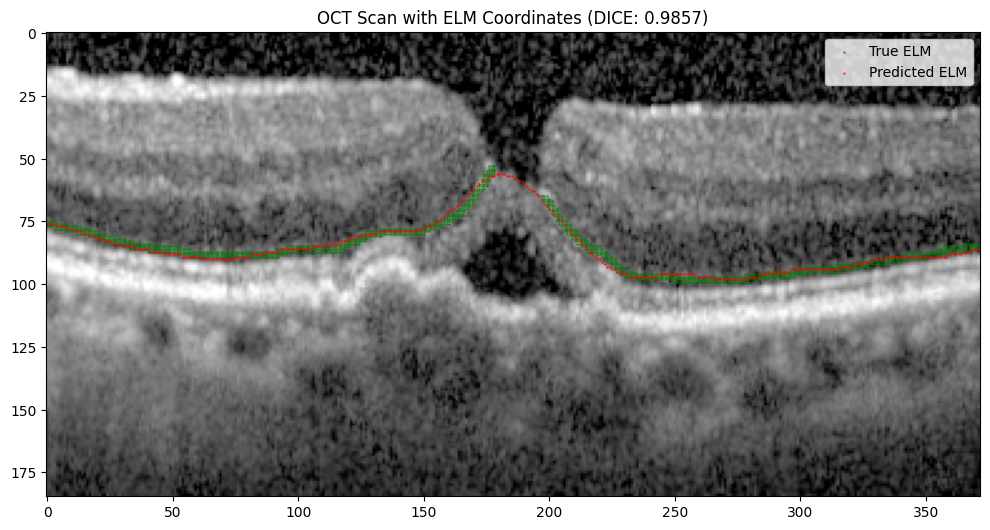

In [65]:
gp_kwargs_obs_lp = dict(
    kernel_options={
        'kernel': 'ExpSineSquared',
        'sigma_f': 1.0,
        'length_scale': 5.0,
        'period': 50.0
    },
    obs=test_obs_lp
)

# Instantiate algorithm using parameters in __init__()
elm_trace_exp = gpet.GPEdgeTracer(init, test_edge_map, **gp_kwargs_obs_lp)

elm_pred_exp = elm_trace_exp()

utils.plot_elm(test_scan, elm_pred_exp, compare=True, true_elm_coords=test_elm)

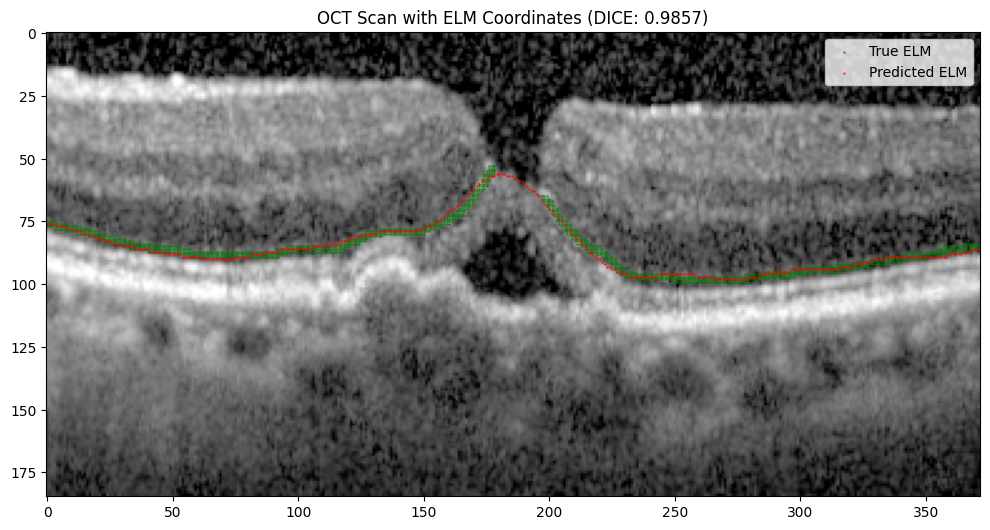

In [66]:
gp_kwargs_obs_lp = dict(
    kernel_options={
        'kernel': 'ExpSineSquared',
        'sigma_f': 1.0,
        'length_scale': 10.0,
        'period': 50.0
    },
    obs=test_obs_lp
)

# Instantiate algorithm using parameters in __init__()
elm_trace_exp = gpet.GPEdgeTracer(init, test_edge_map, **gp_kwargs_obs_lp)

elm_pred_exp = elm_trace_exp()

utils.plot_elm(test_scan, elm_pred_exp, compare=True, true_elm_coords=test_elm)

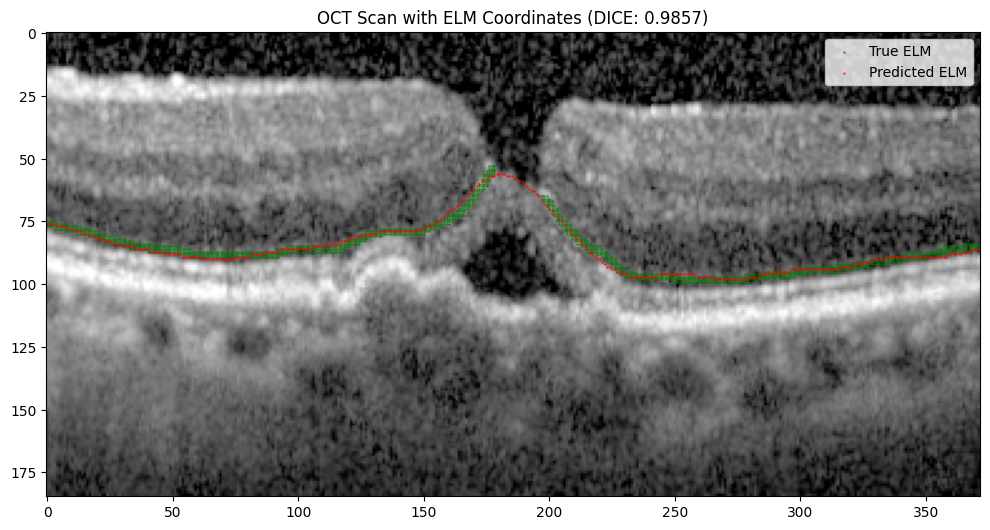

In [68]:
gp_kwargs_obs_lp = dict(
    kernel_options={
        'kernel': 'ExpSineSquared',
        'sigma_f': 1.0,
        'length_scale': 150.0,
        'period': 100.0
    },
    obs=test_obs_lp
)

# Instantiate algorithm using parameters in __init__()
elm_trace_exp = gpet.GPEdgeTracer(init, test_edge_map, **gp_kwargs_obs_lp)

elm_pred_exp = elm_trace_exp()

utils.plot_elm(test_scan, elm_pred_exp, compare=True, true_elm_coords=test_elm)